<a href="https://colab.research.google.com/github/blankqspace/data_analysis_R_homeworks/blob/main/transfer_learning_homework_Artamonova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 8

### Задание 1 (7 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs_torch.ipynb

На датасете lenta_sample.ru  дообучите две модели - modernbert-base (из семинара) и rumodernbert-base (https://huggingface.co/deepvk/RuModernBERT-base). Оцените разницу в качестве сравнив поклассовые метрики (classification_report)

Для обоих моделей качество должно быть >0.10 по f-мере (прогоните несколько экспериментов если у вас получаются нули, изменяя параметры).
Также для обоих моделей попробуйте дообучать модель и целиком и дообучать только последний слой.
Для RuModernBERT дополнительно сравните модель, которая использует первый вектор (cls токен, как в семинаре), так и усредненный вектор по всем hidden_state, который выдает bert.


### Подзадание на 1 балл
Дообучите любую из моделей, добавляя к BERT основе не только один линейный слой, но и один слой LSTM. Финальное состояние из этого слоя должно подаваться с новый линейный классификационный слой.

In [1]:
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt

import torch
from transformers import AutoModel, AutoTokenizer

from tqdm.auto import tqdm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [19]:
data = pd.read_csv('lenta_sample.csv')
data['topic'].value_counts()

texts = data.text.values
topics = data.topic.values

id2label = {i: l for i, l in enumerate(sorted(set(topics)))}
label2id = {l: i for i, l in id2label.items()}

targets = [label2id[t] for t in topics]

train_texts, valid_texts, train_targets, valid_targets = train_test_split(
texts, targets, test_size=0.05, random_state=42
)

In [18]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):

        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)

        self.MAX_LEN = MAX_LEN
        self.length = len(texts)

        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [4]:
class CLF_CLS(nn.Module):

  def __init__(self, pretrained_model, num_classes):
    super().__init__()
    self.bert = pretrained_model
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(768, num_classes)
    self.act = nn.LogSoftmax(1)

  def forward(self, texts):
    mask = (texts!=tokenizer.pad_token_id).long()
    hidden = self.bert(texts, attention_mask=mask)[0]
    cls = hidden[:,0]
    return self.act(self.fc(self.drop(cls)))

In [5]:
class CLF_AVG(nn.Module):

    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.bert = pretrained_model
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(dim=1)

    def forward(self, texts):
        mask = (texts != tokenizer.pad_token_id).long()

        hidden = self.bert(
            texts,
            attention_mask=mask
        )[0]  # [batch, seq_len, hidden]

        mask = mask.unsqueeze(-1)            # [batch, seq_len, 1]
        pooled = (hidden * mask).sum(dim=1) / mask.sum(dim=1)

        logits = self.fc(self.drop(pooled))
        return self.act(logits)


In [17]:
def train(model, iterator, optimizer, criterion, print_every=1000):

    epoch_loss = []
    epoch_f1 = []

    model.train()

    for i, (texts, ys) in enumerate(iterator):

        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))



        loss.backward()
        optimizer.step()
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')

    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:

            predictions = model(texts.to(device))
            loss = criterion(predictions, ys.to(device))
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()


            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

    return np.mean(epoch_f1)# / len(iterator)

In [ ]:
MAX_LEN = 512

train_dataset = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
valid_dataset = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=32, shuffle=False
)

In [10]:
from sklearn.metrics import f1_score, classification_report

def run_experiment(model_id, pooling, freeze_bert, epochs=10, lr=2e-4):
  print("=" * 80)
  print(f"Model: {model_id}")
  print(f"Pooling: {pooling}")
  print(f"Freeze BERT: {freeze_bert}")
  print("=" * 80)

  tokenizer = AutoTokenizer.from_pretrained(model_id)
  bert = AutoModel.from_pretrained(model_id)

  if freeze_bert:
        for p in bert.parameters():
            p.requires_grad = False

In [11]:
def run_experiment(model_id, pooling,freeze_bert, epochs=10,lr=2e-4):
    print("=" * 80)
    print(f"Model: {model_id}")
    print(f"Pooling: {pooling}")
    print(f"Freeze BERT: {freeze_bert}")
    print("=" * 80)

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    bert = AutoModel.from_pretrained(model_id)

    # заморозка берта
    if freeze_bert:
        for p in bert.parameters():
            p.requires_grad = False

    # токен cls или hidden_state - rumodernbert specific
    if pooling == "cls":
        model = CLF_CLS(bert, num_classes=len(label2id))
    elif pooling == "avg":
        model = CLF_AVG(bert, num_classes=len(label2id))
    else:
        raise ValueError("pooling must be 'cls' or 'avg'")

    model = model.to(device)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=lr)
    criterion = nn.NLLLoss().to(device)

    # обучение
    for epoch in range(epochs):
        f1_tr = train(model, train_loader, optimizer, criterion)
        f1_val = evaluate(model, valid_loader, criterion)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"train f1: {f1_tr:.4f} | val f1: {f1_val:.4f}")

    # метрики
    model.eval()
    preds = []

    with torch.no_grad():
        for texts, _ in valid_loader:
            outputs = model(texts.to(device))
            preds.extend(outputs.cpu().argmax(1).tolist())

    print("\nClassification report:")
    print(classification_report(valid_targets, preds))

    return preds


In [42]:
# ModernBERT — CLS — frozen
run_experiment(
    model_id="answerdotai/ModernBERT-base",
    pooling="cls",
    freeze_bert=True)

Model: answerdotai/ModernBERT-base
Pooling: cls
Freeze BERT: True
Epoch 1/10 | train f1: 0.0729 | val f1: 0.0968
Epoch 2/10 | train f1: 0.1042 | val f1: 0.1290
Epoch 3/10 | train f1: 0.1337 | val f1: 0.1290
Epoch 4/10 | train f1: 0.1389 | val f1: 0.1290
Epoch 5/10 | train f1: 0.1649 | val f1: 0.1935
Epoch 6/10 | train f1: 0.1892 | val f1: 0.2258
Epoch 7/10 | train f1: 0.1997 | val f1: 0.1290
Epoch 8/10 | train f1: 0.2031 | val f1: 0.1935
Epoch 9/10 | train f1: 0.2552 | val f1: 0.2903
Epoch 10/10 | train f1: 0.2483 | val f1: 0.2581

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.33      0.25      0.29         4
           4       0.50      1.00      0.67         1
           5       0.12      1.00      0.22         1
           6       1.00      1.00      1.00         1
      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[4,
 8,
 2,
 2,
 3,
 5,
 8,
 5,
 13,
 15,
 5,
 15,
 5,
 3,
 11,
 4,
 2,
 14,
 2,
 2,
 5,
 5,
 5,
 5,
 13,
 11,
 6,
 3,
 2,
 13,
 13]

In [43]:
# ModernBERT — CLS — full fine-tuning
run_experiment(
    model_id="answerdotai/ModernBERT-base",
    pooling="cls",
    freeze_bert=False)

Model: answerdotai/ModernBERT-base
Pooling: cls
Freeze BERT: False
Epoch 1/10 | train f1: 0.0833 | val f1: 0.0323
Epoch 2/10 | train f1: 0.0781 | val f1: 0.1290
Epoch 3/10 | train f1: 0.0781 | val f1: 0.0323
Epoch 4/10 | train f1: 0.0694 | val f1: 0.0323
Epoch 5/10 | train f1: 0.0868 | val f1: 0.0968
Epoch 6/10 | train f1: 0.1059 | val f1: 0.0645
Epoch 7/10 | train f1: 0.1354 | val f1: 0.1290
Epoch 8/10 | train f1: 0.1701 | val f1: 0.0968
Epoch 9/10 | train f1: 0.2448 | val f1: 0.1935
Epoch 10/10 | train f1: 0.3160 | val f1: 0.2903

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.22      1.00      0.36         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.50      1.00      0.67         1
     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[3,
 6,
 3,
 3,
 3,
 15,
 3,
 3,
 3,
 16,
 14,
 3,
 4,
 3,
 11,
 16,
 3,
 11,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 11,
 6,
 3,
 3,
 13,
 4]

In [51]:
# RuModernBERT — CLS — frozen
run_experiment(
    model_id="deepvk/RuModernBERT-base",
    pooling="cls",
    freeze_bert=True,
    lr=2e-4,
    epochs=15)

Model: deepvk/RuModernBERT-base
Pooling: cls
Freeze BERT: True
Epoch 1/15 | train f1: 0.0833 | val f1: 0.0968
Epoch 2/15 | train f1: 0.0851 | val f1: 0.0645
Epoch 3/15 | train f1: 0.0833 | val f1: 0.0968
Epoch 4/15 | train f1: 0.0608 | val f1: 0.0323
Epoch 5/15 | train f1: 0.0851 | val f1: 0.0323
Epoch 6/15 | train f1: 0.0938 | val f1: 0.0323
Epoch 7/15 | train f1: 0.0972 | val f1: 0.0323
Epoch 8/15 | train f1: 0.0903 | val f1: 0.0323
Epoch 9/15 | train f1: 0.0938 | val f1: 0.0323
Epoch 10/15 | train f1: 0.0903 | val f1: 0.0323
Epoch 11/15 | train f1: 0.0938 | val f1: 0.0968
Epoch 12/15 | train f1: 0.0851 | val f1: 0.0323
Epoch 13/15 | train f1: 0.0833 | val f1: 0.0323
Epoch 14/15 | train f1: 0.0938 | val f1: 0.0323
Epoch 15/15 | train f1: 0.0851 | val f1: 0.0645

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[11,
 11,
 5,
 5,
 11,
 11,
 11,
 11,
 11,
 5,
 5,
 11,
 11,
 5,
 5,
 11,
 11,
 11,
 5,
 11,
 11,
 5,
 5,
 11,
 11,
 5,
 11,
 11,
 5,
 5,
 11]

In [53]:
# RuModernBERT — CLS — full fine-tuning
run_experiment(
    model_id="deepvk/RuModernBERT-base",
    pooling="cls",
    freeze_bert=False,
    lr=1e-5)

# тут помогло уменьшение learning rate, хотя по моим ощущения заморозка на rumodernBERT с таким маленьким датасетом не даст результатов выше 1.6 (у меня не полчилось, хотя и эпохи увеличивала, и лернинг рейт) - эта комбинация пулинга и заморозки у меня не получилась :(((

Model: deepvk/RuModernBERT-base
Pooling: cls
Freeze BERT: False
Epoch 1/10 | train f1: 0.0729 | val f1: 0.0323
Epoch 2/10 | train f1: 0.1319 | val f1: 0.0645
Epoch 3/10 | train f1: 0.1198 | val f1: 0.0645
Epoch 4/10 | train f1: 0.1858 | val f1: 0.0968
Epoch 5/10 | train f1: 0.2951 | val f1: 0.0323
Epoch 6/10 | train f1: 0.3837 | val f1: 0.1935
Epoch 7/10 | train f1: 0.5174 | val f1: 0.1613
Epoch 8/10 | train f1: 0.6441 | val f1: 0.0968
Epoch 9/10 | train f1: 0.8142 | val f1: 0.1613
Epoch 10/10 | train f1: 0.9167 | val f1: 0.0968

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.17      0.25      0.20         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[3,
 8,
 3,
 10,
 3,
 15,
 13,
 6,
 12,
 15,
 4,
 12,
 8,
 8,
 14,
 8,
 0,
 4,
 2,
 2,
 5,
 8,
 11,
 12,
 3,
 12,
 3,
 6,
 3,
 4,
 13]

In [54]:
# RuModernBERT — AVG — full fine-tuning
run_experiment(
    model_id="deepvk/RuModernBERT-base",
    pooling="avg",
    freeze_bert=False)

Model: deepvk/RuModernBERT-base
Pooling: avg
Freeze BERT: False
Epoch 1/10 | train f1: 0.0764 | val f1: 0.0645
Epoch 2/10 | train f1: 0.0781 | val f1: 0.1613
Epoch 3/10 | train f1: 0.0903 | val f1: 0.1290
Epoch 4/10 | train f1: 0.0938 | val f1: 0.0645
Epoch 5/10 | train f1: 0.0903 | val f1: 0.0323
Epoch 6/10 | train f1: 0.0694 | val f1: 0.0645
Epoch 7/10 | train f1: 0.0747 | val f1: 0.0323
Epoch 8/10 | train f1: 0.0747 | val f1: 0.1290
Epoch 9/10 | train f1: 0.0938 | val f1: 0.0323
Epoch 10/10 | train f1: 0.0885 | val f1: 0.1290

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.17      0.50      0.25         4
           4       0.33      1.00      0.50         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[3,
 8,
 4,
 3,
 2,
 3,
 2,
 3,
 8,
 8,
 8,
 8,
 3,
 3,
 5,
 4,
 8,
 3,
 8,
 8,
 8,
 3,
 3,
 5,
 2,
 3,
 2,
 4,
 3,
 3,
 8]

In [56]:
del model, optimizer, criterion
torch.cuda.empty_cache()

In [57]:
# RuModernBERT — AVG — frozen
run_experiment(
    model_id="deepvk/RuModernBERT-base",
    pooling="avg",
    freeze_bert=True)

Model: deepvk/RuModernBERT-base
Pooling: avg
Freeze BERT: True
Epoch 1/10 | train f1: 0.0816 | val f1: 0.0645
Epoch 2/10 | train f1: 0.0833 | val f1: 0.0968
Epoch 3/10 | train f1: 0.0833 | val f1: 0.0968
Epoch 4/10 | train f1: 0.0833 | val f1: 0.0323
Epoch 5/10 | train f1: 0.1007 | val f1: 0.0968
Epoch 6/10 | train f1: 0.1024 | val f1: 0.0645
Epoch 7/10 | train f1: 0.1163 | val f1: 0.0323
Epoch 8/10 | train f1: 0.1094 | val f1: 0.1290
Epoch 9/10 | train f1: 0.1267 | val f1: 0.0968
Epoch 10/10 | train f1: 0.1128 | val f1: 0.0645

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.20      0.50      0.29         2
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         1
           5       0.08      1.00      0.14         1
           6       0.00      0.00      0.00         1
         

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[2,
 5,
 5,
 8,
 5,
 5,
 11,
 15,
 8,
 3,
 5,
 3,
 5,
 8,
 2,
 3,
 3,
 5,
 5,
 2,
 3,
 5,
 5,
 15,
 2,
 5,
 3,
 5,
 5,
 3,
 2]

In [60]:
results = [
    {
        "name": "ModernBERT CLS frozen",
        "val_f1": 0.2903
    },
    {
        "name": "ModernBERT CLS full",
        "val_f1": 0.2903
    },
    {
        "name": "RuModernBERT CLS frozen",
        "val_f1": 0.0968
    },
    {
        "name": "RuModernBERT CLS full",
        "val_f1":  0.1613
    },
    {
        "name": "RuModernBERT AVG frozen",
        "val_f1": 0.1290
    },
    {
        "name": "RuModernBERT AVG full",
        "val_f1": 0.1613
    }
]

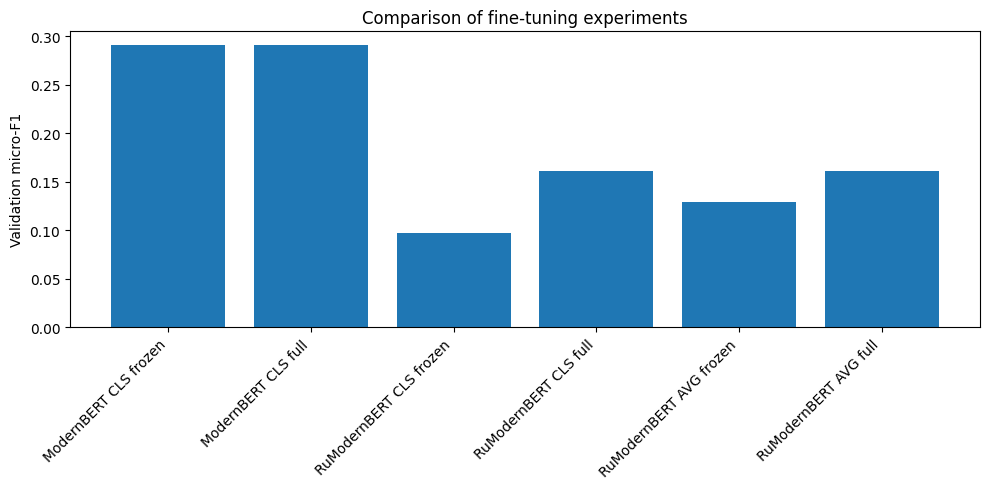

In [61]:
names = [r["name"] for r in results]
scores = [r["val_f1"] for r in results]

plt.figure(figsize=(10, 5))
plt.bar(names, scores)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Validation micro-F1")
plt.title("Comparison of fine-tuning experiments")

plt.tight_layout()
plt.show()

In [62]:
# BERT → LSTM → Linear → LogSoftmax
class CLF_BERT_LSTM(nn.Module):
    def __init__(self, bert_model, num_classes, lstm_hidden=256, lstm_layers=1, bidirectional=False):
        super().__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(0.3)

        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        lstm_out_size = lstm_hidden * (2 if bidirectional else 1)
        self.fc = nn.Linear(lstm_out_size, num_classes)
        self.act = nn.LogSoftmax(dim=1)

    def forward(self, texts):
        mask = (texts != tokenizer.pad_token_id).long()
        bert_out = self.bert(texts, attention_mask=mask)[0]

        # Пропускаем через LSTM
        # LSTM возвращает output и (h_n, c_n)
        lstm_out, (h_n, c_n) = self.lstm(bert_out)

        # Финальное hidden state последнего слоя LSTM
        if self.lstm.bidirectional:
            final_h = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            final_h = h_n[-1]

        logits = self.fc(self.drop(final_h))
        return self.act(logits)

In [63]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
bert = AutoModel.from_pretrained(model_id)

for p in bert.parameters():
    p.requires_grad = True

model = CLF_BERT_LSTM(bert, num_classes=len(label2id)).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
criterion = nn.NLLLoss().to(device)

epochs = 10

for epoch in range(epochs):
    f1_tr = train(model, train_loader, optimizer, criterion)
    f1_val = evaluate(model, valid_loader, criterion)
    print(f"Epoch {epoch+1} | train f1: {f1_tr:.4f} | val f1: {f1_val:.4f}")

Epoch 1 | train f1: 0.0573 | val f1: 0.0968
Epoch 2 | train f1: 0.0747 | val f1: 0.0645
Epoch 3 | train f1: 0.0764 | val f1: 0.0323
Epoch 4 | train f1: 0.0885 | val f1: 0.1935
Epoch 5 | train f1: 0.1059 | val f1: 0.0968
Epoch 6 | train f1: 0.0781 | val f1: 0.1290
Epoch 7 | train f1: 0.0903 | val f1: 0.1290
Epoch 8 | train f1: 0.0903 | val f1: 0.0645
Epoch 9 | train f1: 0.1181 | val f1: 0.0000
Epoch 10 | train f1: 0.0816 | val f1: 0.0968


overall ощущение, что все проблемы из-за маленького датасета и модель переобучается и метрики скачут

## Задание 2 (2 балла)

Проведите несколько экспериментов с gradual unfreezing. Используя ту же задачу и датасет, что в первом задании, дообучите модели таким образом, что в начале обучения весь backbone BERT заморожен и дообучение происходит только на новом Linear/dense/fc слое, но после каждой N эпохи, размораживайте (`_requires_grad = True`) какую-то часть параметров BERT. Проведите как минимум 3 эксперимента с разными методиками разморозки. Вы можете придумать их сами, но вот несколько примеров - 1) разморозка начинается с конца модели и каждые две эпохи размораживается несколько слоев до тех пор пока не разморозятся все слои всключая первый эмбеддинг слой 2) разморозка начинается с начала (то есть сначала размораживается только embedding слой), а со временем включаются и все последующие 3) таргетировано размораживаются сначала слои query трансформаций, потом key, потом value 4) или даже можете попробовать сначала разморозить все слои и наоборот замораживать части с прогрессом обучения. Для каждого эксперимента сохраните метрики на каждой эпохе и финальную метрику, сравните их между собой - какой schedule сработал лучше всего? Сработало ли что-то лучше дефолтного подхода из первого задания?
